The script used to generate the data for the parts 2.3 and 2.4 of the report. 

In the first part, we compare networks with ReLU or Sigmoid activation and with or without exponential binning. The goal is only to compare the training speed.
In the second part, we compare FBP, SIRT, NNFPB in the reconstruction of a MOF particle from HSH75-Pd-HAADF_hdr0.ali (this code works for .mrc and .ali files), a stack of 29 projections between -70° and 70°.

For an introduction on Python classes, see tutorial_classes.ipynb.
For an introduction on how neural networks works, see https://www.3blue1brown.com/topics/neural-networks.
For more details about the training procedure and the overall pytorch framework, see https://pytorch.org/tutorials/beginner/basics/intro.html.

For more details about a particular function / method, see the specific documentation in the code.

For more details about NN-FBP implementation, see the original article: Fast Tomographic Reconstruction from Limited Data Using Artificial Neural
Networks, D. M. Pelt and al., 2013 (https://ieeexplore.ieee.org/document/6607157).

In [1]:
### Imports ###

from nntomo.utilities import get_MSE_loss
from nntomo.network import nnfbp_training, get_MSE_evolution
from nntomo.nnfbp import DatasetNNFBP
from nntomo.projection_stack import ProjectionStack
from nntomo.volume import Volume
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
Nh = 8

### I. Influence of the activation function and the binning procedure on the training process

In [4]:
# Generation of the training and validation datasets

training_spheres = Volume.random_spheres(40, shape=512, set01 = True)
training_projections = ProjectionStack.from_volume(training_spheres, 9, 'full')
training_dataset_bin = DatasetNNFBP(training_projections, training_spheres, n_input = 10_000)
training_dataset_nobin = DatasetNNFBP(training_projections, training_spheres, n_input = 10_000, binning = False)

validation_spheres = Volume.random_spheres(40, shape=512, set01 = True)
validation_projections = ProjectionStack.from_volume(validation_spheres, 9, 'full')
validation_dataset_bin = DatasetNNFBP(validation_projections, validation_spheres, n_input = 10_000)
validation_dataset_nobin = DatasetNNFBP(validation_projections, validation_spheres, n_input = 10_000, binning = False)

Generation of the spheres: [████████████████████████████████████████████████████████████] 40/40 Est wait 00:0.00

Generation of the spheres: [████████████████████████████████████████████████████████████] 40/40 Est wait 00:0.00



<pre>
The random spheres:                                                  9 projections:

<img src="data/gifs/random_spheres.gif" width="300"/>                              <img src="data/gifs/randspheres_proj.gif" width="300"/>
</pre>

In [5]:
# Training of the 4 networks

network_relu_bin = nnfbp_training(training_dataset_bin, validation_dataset_bin, Nh, max_epoch=50, custom_id='relu_bin')
network_sigm_bin = nnfbp_training(training_dataset_bin, validation_dataset_bin, Nh, max_epoch=50, activation='sigmoid', custom_id='sigm_bin')
network_relu_nobin = nnfbp_training(training_dataset_nobin, validation_dataset_nobin, Nh, max_epoch=50, custom_id='relu_nobin')
network_sigm_nobin = nnfbp_training(training_dataset_nobin, validation_dataset_nobin, Nh, max_epoch=50, activation='sigmoid', custom_id='sigm_nobin')

Epoch 51 (n=0) | Best avg MSELoss(): 0.013128 | End of training                                 
Epoch 51 (n=0) | Best avg MSELoss(): 0.013685 | End of training                                 
Epoch 51 (n=4) | Best avg MSELoss(): 0.004836 | End of training                                 
Epoch 51 (n=0) | Best avg MSELoss(): 0.013586 | End of training                                 


In [6]:
# Computation of the evolution of MSE during training - we test on an other set of random spheres

test_spheres = Volume.random_spheres(40, shape=512, set01 = True)
test_projections = ProjectionStack.from_volume(test_spheres, 9, 'full')

mse_relu_bin = get_MSE_evolution(network_relu_bin.id, test_projections, test_spheres, threshold=.5)
mse_sigm_bin = get_MSE_evolution(network_sigm_bin.id, test_projections, test_spheres, threshold=.5)
mse_relu_nobin = get_MSE_evolution(network_relu_nobin.id, test_projections, test_spheres, threshold=.5)
mse_sigm_nobin = get_MSE_evolution(network_sigm_nobin.id, test_projections, test_spheres, threshold=.5)

Generation of the spheres: [████████████████████████████████████████████████████████████] 40/40 Est wait 00:0.00

MSE computations:[████████████████████████████████████████████████████████████] 51/51 Est wait 00:0.05


MSE computations:[████████████████████████████████████████████████████████████] 51/51 Est wait 00:0.05


MSE computations:[████████████████████████████████████████████████████████████] 51/51 Est wait 00:0.04


MSE computations:[████████████████████████████████████████████████████████████] 51/51 Est wait 00:0.04




In [ ]:
plt.plot(mse_relu_bin, label='ReLu + binning')
plt.plot(mse_sigm_bin, label='Sigmoid + binning')
plt.plot(mse_relu_nobin, label='ReLu, no binning')
plt.plot(mse_sigm_nobin, label='Sigmoid, no binning')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Evolution of MSE during training for the test volume, for NNFBP models with\n different activation functions and with or without exponential binning.\n"
          "Each model has 8 hidden nodes and is trained to reconstruct random spheres \nwith 9 projections. Before computing the MSE, voxels of the NNFBP are \n"
          "set to 0 or 1, with a segmentation threshold of 0.5.")
plt.grid()
plt.legend()
plt.xlim(0,50)
plt.ylim(0,0.06)
plt.show()

### II. Comparison of reconstruction methods

<pre>
The original 29 projections from STEM measurements.           A subset of 8 projections

<img src="data/gifs/particule_29projs.gif" width="300"/>                                  <img src="data/gifs/particule_8projs.gif" width="300"/>
</pre>

In [10]:
# Data import

mof_projections_file = "data/projection_files/HSH75-Pd-HAADF_hdr0.ali"
mof_29proj = ProjectionStack.from_mrc_file(mof_projections_file, 'tem').get_resized_proj(512)
sirt_29proj = mof_29proj.get_SIRT_reconstruction(min_eps_var=0.01, print_n_iter=True, force_positive_values=False)
sirt_29proj.save()
print(sirt_29proj.volume.min(), sirt_29proj.volume.max())

Map ID string not found - not an MRC file, or file is corrupt
Unrecognised machine stamp: 0x00 0x00 0x00 0x00


Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt_HSH75-Pd-HAADF_hdr0-resized512.mrc.
 ID: sirt_HSH75-Pd-HAADF_hdr0-resized512
-471.53085 443.48975


In [11]:
# Chosen SIRT segmentation threshold, computation of the associated projections. These projections will be used aterward for reconstruction, and the segmented SIRT will be used
# as a reference volume (see report for more explanations).

sirt_29proj = sirt_29proj.get_segmented_volume(188/255)
mof_29proj = ProjectionStack.from_volume(sirt_29proj, 29, 'tem')
mof_29proj.save()

Saving projections...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\projection_files\sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th.mrc.
 ID: sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th


<pre>
The SIRT reference reconstruction:                       The 29 associated projections:

<img src="data/gifs/particule_sirtref.gif" width="300"/>                              <img src="data/gifs/particule_sirtrefprojs.gif" width="300"/>
</pre>

In [ ]:
list_Nth = [9, 18, 36]
list_tem_Nth = [8, 15, 29]

In [6]:
# Datasets for NNFBP trained wih spheres

training_spheres = Volume.random_spheres(40, shape=512)
list_training_projections_spheres = [ProjectionStack.from_volume(training_spheres, i, 'full') for i in list_Nth]
list_training_datasets_spheres = [DatasetNNFBP(training_projections, training_spheres) for training_projections in list_training_projections_spheres]

validation_spheres = Volume.random_spheres(40, shape=512)
list_validation_projections_spheres = [ProjectionStack.from_volume(validation_spheres, i, 'full') for i in list_Nth]
list_validation_datasets_spheres = [DatasetNNFBP(validation_projections, validation_spheres) for validation_projections in list_validation_projections_spheres]

Generation of the spheres: [████████████████████████████████████████████████████████████] 40/40 Est wait 00:0.00

Generation of the spheres: [████████████████████████████████████████████████████████████] 40/40 Est wait 00:0.00



In [14]:
# NNFBP-Spheres training

list_networks_spheres = []
for i in range(len(list_Nth)):
    list_networks_spheres.append(nnfbp_training(list_training_datasets_spheres[i], list_validation_datasets_spheres[i], Nh))

Epoch 77 (n=25) | Best avg MSELoss(): 0.040412 | End of training                                 
Epoch 118 (n=25) | Best avg MSELoss(): 0.029567 | End of training                                 
Epoch 133 (n=25) | Best avg MSELoss(): 0.025787 | End of training                                 


In [15]:
# Datasets for NNFBP trained wih ellipses

training_ellipses = Volume.stack_7ellipses(100, shape=512)
list_training_projections_ellipses = [ProjectionStack.from_volume(training_ellipses, i, 'full') for i in list_Nth]
list_training_datasets_ellipses = [DatasetNNFBP(training_projections, training_ellipses) for training_projections in list_training_projections_ellipses]

validation_ellipses = Volume.stack_7ellipses(100, shape=512)
list_validation_projections_ellipses = [ProjectionStack.from_volume(validation_ellipses, i, 'full') for i in list_Nth]
list_validation_datasets_ellipses = [DatasetNNFBP(validation_projections, validation_ellipses) for validation_projections in list_validation_projections_ellipses]

Generation of the ellipses: [████████████████████████████████████████████████████████████] 100/100 Est wait 00:0.0

Generation of the ellipses: [████████████████████████████████████████████████████████████] 100/100 Est wait 00:0.0



In [16]:
# NNFBP-Ellipses training

list_networks_ellipses = []
for i in range(len(list_Nth)):
    list_networks_ellipses.append(nnfbp_training(list_training_datasets_ellipses[i], list_validation_datasets_ellipses[i], Nh))

Epoch 151 (n=25) | Best avg MSELoss(): 0.182200 | End of training                                 
Epoch 115 (n=25) | Best avg MSELoss(): 0.108085 | End of training                                 
Epoch 186 (n=25) | Best avg MSELoss(): 0.080389 | End of training                                 


In [17]:
# MSE computations

mse_fbp = []
mse_sirt = []
mse_nnfbp_spheres = []
mse_nnfbp_ellipses = []

for i in range(len(list_Nth)):
    uio67_stack_sub = mof_29proj.get_proj_subset(list_tem_Nth[i])

    fbp_rec = uio67_stack_sub.get_FBP_reconstruction()
    fbp_rec.save()
    mse_fbp.append(get_MSE_loss(sirt_29proj, fbp_rec, only_inscribed_disc=True))

    sirt_rec = uio67_stack_sub.get_SIRT_reconstruction(min_eps_var=0.01, print_n_iter=True, force_positive_values=False)
    sirt_rec.save()
    mse_sirt.append(get_MSE_loss(sirt_29proj, sirt_rec, only_inscribed_disc=True))

    nnfbp_rec_spheres = uio67_stack_sub.get_NNFBP_reconstruction(list_networks_spheres[i], show_progressbar=False)
    nnfbp_rec_spheres.save()
    mse_nnfbp_spheres.append(get_MSE_loss(sirt_29proj, nnfbp_rec_spheres, only_inscribed_disc=True))

    nnfbp_rec_ellipses = uio67_stack_sub.get_NNFBP_reconstruction(list_networks_ellipses[i], show_progressbar=False)
    nnfbp_rec_ellipses.save()
    mse_nnfbp_ellipses.append(get_MSE_loss(sirt_29proj, nnfbp_rec_ellipses, only_inscribed_disc=True))

Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\fbp_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8.mrc.
 ID: fbp_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\sirt_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8.mrc.
 ID: sirt_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8
Saving volume...
File saved at c:\Users\Admin-tomo\Documents\tomo-reconstruction-alix\github_repository\nn-tomo-reconstruction\scripts\data\volume_files\nnfbp[randspheres512-full9th][randspheres512]bin8h_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8.mrc.
 ID: nnfbp[randspheres512-full9th][randspheres512]bin8h_sirt_HSH75-Pd-HAADF_hdr0-resized512-segm0.74-tem29th-sub8
Saving volume...
File saved at c:\Users\Adm

[0.005126405507326126, 0.0023970601614564657, 0.0011802257504314184] [0.0007900000782683492, 0.0004732541274279356, 0.00033784506376832724] [0.0002450369647704065, 0.00014637723506893963, 0.0003062390023842454] [0.0002431623579468578, 0.00018206653476227075, 0.00012597112799994648]


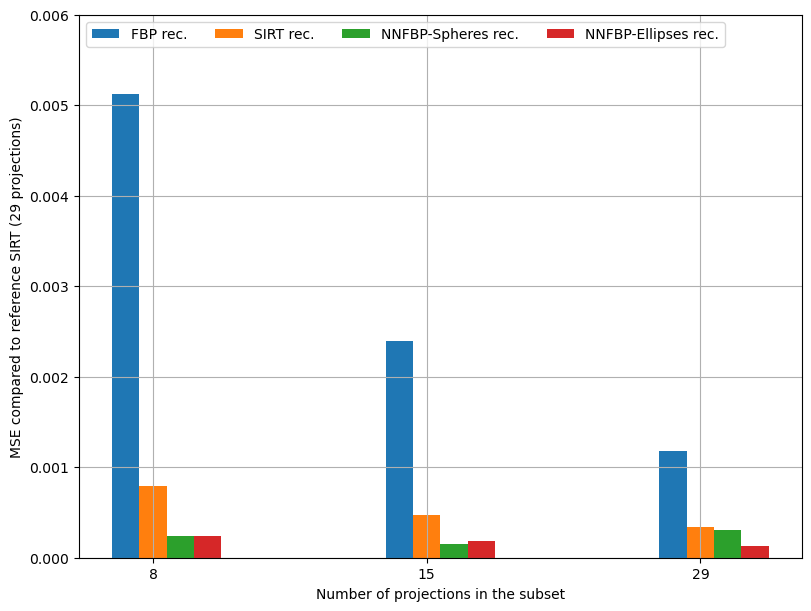

In [19]:
mse_lists = {
    'FBP rec.': mse_fbp,
    'SIRT rec.': mse_sirt,
    'NNFBP-Spheres rec.': mse_nnfbp_spheres,
    'NNFBP-Ellipses rec.': mse_nnfbp_ellipses,
}

x = np.arange(len(mse_sirt))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,6))

for attribute, measurement in mse_lists.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Number of projections in the subset")
ax.set_ylabel('MSE compared to reference SIRT (29 projections)')
ax.set_xticks(x + width, list_tem_Nth)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.006)
ax.grid()
plt.show()

<pre>
The SIRT reconstruction with 8 projections :              The NNFBP-Ellipses reconstruction with 8 projections:
(threshold 153/255)                                       (threshold 153/255)


<img src="data/gifs/particule_sirt8.gif" width="300"/>                               <img src="data/gifs/particule_nnfbp8.gif" width="300"/>
</pre>